In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/zf/26z9dj9s4rgb9txx_1j9fkv80000gn/T/ipykernel_19255/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [10]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [11]:
from sklearn.model_selection import train_test_split

# Dividir los datos en train y validación (80-20)
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", data_train.shape)
print("Tamaño del conjunto de validación:", data_val.shape)

Tamaño del conjunto de entrenamiento: (800, 2)
Tamaño del conjunto de validación: (200, 2)


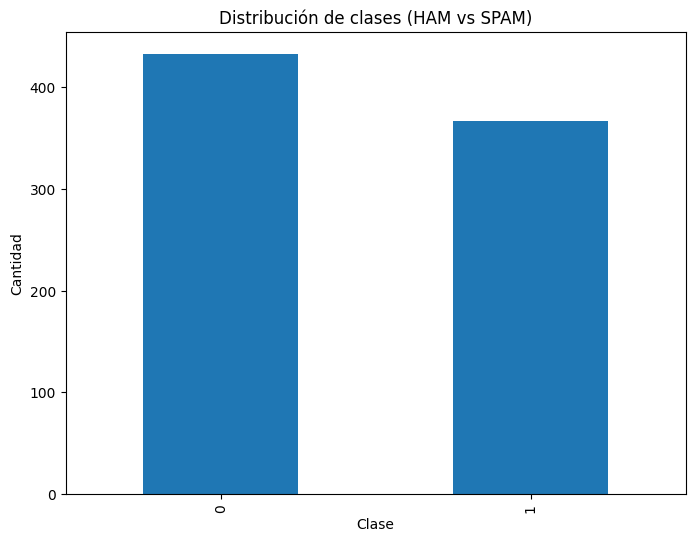

In [12]:
# Visualización de la distribución de clases
plt.figure(figsize=(8, 6))
data_train['label'].value_counts().plot(kind='bar')
plt.title('Distribución de clases (HAM vs SPAM)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

## Data Preprocessing

In [13]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [14]:
import re
from bs4 import BeautifulSoup

- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [15]:
def clean_text(text):
    try:
        # Primero verificamos si el texto está vacío o es None
        if not text or pd.isna(text):
            return ""
            
        # Convertimos a string en caso de que no lo sea
        text = str(text)
        
        # Remover HTML (ignorando warnings)
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            soup = BeautifulSoup(text, 'html.parser', from_encoding='utf-8')
            text = soup.get_text()
        
        # Remover caracteres especiales y números
        text = re.sub('[^a-zA-Z]', ' ', text)
        
        # Convertir a minúsculas
        text = text.lower()
        
        # Remover espacios múltiples
        text = re.sub('\s+', ' ', text).strip()
        
        return text
    except Exception as e:
        print(f"Error procesando texto: {e}")
        return ""

# Aplicar limpieza a los datos
data_train['cleaned_text'] = data_train['text'].apply(clean_text)
data_val['cleaned_text'] = data_val['text'].apply(clean_text)

# Mostrar ejemplo de la limpieza
print("Ejemplo de texto original:")
print(data_train['text'].iloc[0])
print("\nEjemplo de texto limpio:")
print(data_train['cleaned_text'].iloc[0])

Ejemplo de texto original:
----------- REGARDS, MR NELSON SMITH.KINDLY REPLY ME ON MY PRIVATE EMAIL ADDRESS;nelsonsmith2000@yahoo.com

Ejemplo de texto limpio:
regards mr nelson smith kindly reply me on my private email address nelsonsmith yahoo com


In [16]:
# Características adicionales
def extract_more_features(df):
    # URLs
    df['url_count'] = df['text'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    # Números
    df['number_count'] = df['text'].str.count(r'\d+')
    
    # Ratio de mayúsculas
    df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    
    return df

data_train = extract_more_features(data_train)
data_val = extract_more_features(data_val)

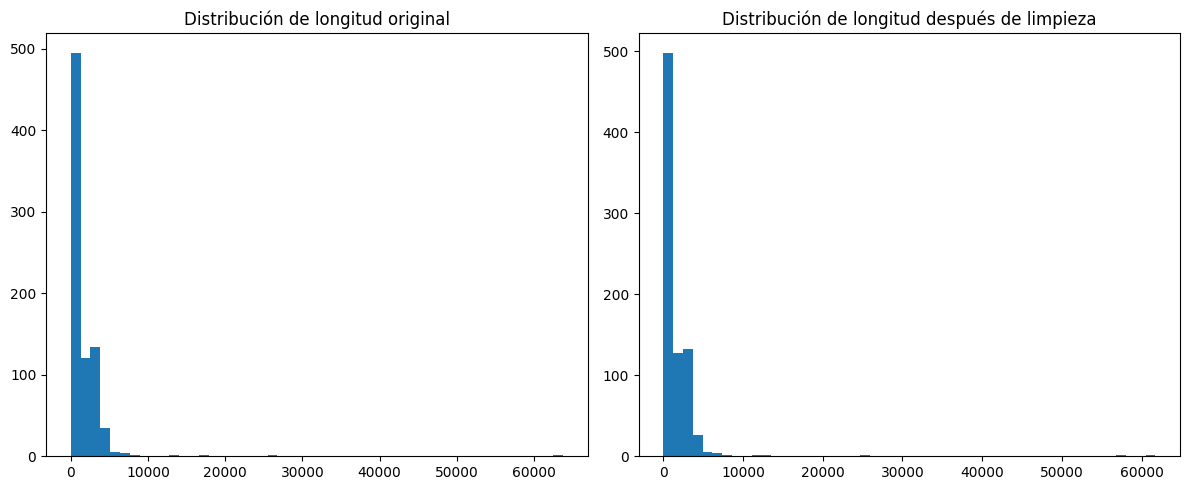

In [17]:
# Análisis de longitud de mensajes
data_train['original_length'] = data_train['text'].str.len()
data_train['cleaned_length'] = data_train['cleaned_text'].str.len()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data_train['original_length'], bins=50)
plt.title('Distribución de longitud original')
plt.subplot(1, 2, 2)
plt.hist(data_train['cleaned_length'], bins=50)
plt.title('Distribución de longitud después de limpieza')
plt.tight_layout()
plt.show()

## Now let's work on removing stopwords
Remove the stopwords.

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

data_train['preprocessed_text'] = data_train['cleaned_text'].apply(remove_stopwords)
data_val['preprocessed_text'] = data_val['cleaned_text'].apply(remove_stopwords)

print("Texto sin stopwords:")
print(data_train['preprocessed_text'].iloc[0])

Texto sin stopwords:
regards mr nelson smith kindly reply private email address nelsonsmith yahoo com


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

data_train['preprocessed_text'] = data_train['preprocessed_text'].apply(lemmatize_text)
data_val['preprocessed_text'] = data_val['preprocessed_text'].apply(lemmatize_text)

print("Texto lematizado:")
print(data_train['preprocessed_text'].iloc[0])

Texto lematizado:
regard mr nelson smith kindly reply private email address nelsonsmith yahoo com


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [20]:
from collections import Counter

# Primero, veamos cómo están los labels
print("Valores únicos en label:")
print(data_train['label'].unique())
print("\nConteo de labels:")
print(data_train['label'].value_counts())

def get_top_words(texts, n=10):
    # Añadimos prints para debug
    print(f"Número de textos recibidos: {len(texts)}")
    print(f"Ejemplo de texto: {list(texts)[:1]}")
    
    words = ' '.join(texts).split()
    print(f"Número total de palabras: {len(words)}")
    return Counter(words).most_common(n)

# Verificamos los textos para cada clase
print("\nEjemplo de texto HAM:")
print(data_train[data_train['label'] == 0]['preprocessed_text'].iloc[0])
print("\nEjemplo de texto SPAM:")
print(data_train[data_train['label'] == 1]['preprocessed_text'].iloc[0])

# Top palabras en mensajes ham
ham_words = get_top_words(data_train[data_train['label'] == 0]['preprocessed_text'])
print("\nTop 10 palabras en mensajes HAM:")
print(ham_words)

# Top palabras en mensajes spam
spam_words = get_top_words(data_train[data_train['label'] == 1]['preprocessed_text'])
print("\nTop 10 palabras en mensajes SPAM:")
print(spam_words)

Valores únicos en label:
[1 0]

Conteo de labels:
label
0    433
1    367
Name: count, dtype: int64

Ejemplo de texto HAM:
able reach oscar supposed send pdb u receive

Ejemplo de texto SPAM:
regard mr nelson smith kindly reply private email address nelsonsmith yahoo com
Número de textos recibidos: 433
Ejemplo de texto: ['able reach oscar supposed send pdb u receive']
Número total de palabras: 18195

Top 10 palabras en mensajes HAM:
[('u', 123), ('state', 117), ('pm', 97), ('would', 94), ('president', 89), ('mr', 89), ('time', 81), ('percent', 80), ('obama', 77), ('call', 74)]
Número de textos recibidos: 367
Ejemplo de texto: ['regard mr nelson smith kindly reply private email address nelsonsmith yahoo com']
Número total de palabras: 96432

Top 10 palabras en mensajes SPAM:
[('e', 2236), ('c', 1188), ('money', 842), ('u', 836), ('account', 740), ('bank', 645), ('fund', 625), ('f', 559), ('transaction', 468), ('p', 458)]


## Extra features

In [21]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

,text,label,cleaned_text,url_count,number_count,uppercase_ratio,original_length,cleaned_length,preprocessed_text,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,regards mr nelson smith kindly reply me on my ...,0,1,0.528302,106,89,regard mr nelson smith kindly reply private em...,1,0,79
535,I have not been able to reach oscar this am. W...,0,i have not been able to reach oscar this am we...,0,1,0.029703,101,95,able reach oscar supposed send pdb u receive,1,0,44
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,huma abedin b i m checking with pat on the k w...,0,2,0.063830,141,135,huma abedin b checking pat k work jack jake re...,1,0,80
557,I can have it announced here on Monday - can't...,0,i can have it announced here on monday can t t...,0,0,0.038462,52,50,announced monday today,1,0,22
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,bank of africaagence san pedro bp san pedro co...,1,17,0.077714,1750,1621,bank africaagence san pedro bp san pedro cote ...,1,1,1058


## How would work the Bag of Words with Count Vectorizer concept?

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(data_train['preprocessed_text'])
X_val_bow = vectorizer.transform(data_val['preprocessed_text'])

print("Forma de la matriz BOW de entrenamiento:", X_train_bow.shape)
print("Forma de la matriz BOW de validación:", X_val_bow.shape)
print("\nPrimeras 10 palabras del vocabulario:")
print(list(vectorizer.vocabulary_.keys())[:10])

Forma de la matriz BOW de entrenamiento: (800, 1000)
Forma de la matriz BOW de validación: (200, 1000)

Primeras 10 palabras del vocabulario:
['regard', 'mr', 'smith', 'kindly', 'reply', 'private', 'email', 'address', 'yahoo', 'com']


## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [23]:
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer_tfidf.fit_transform(data_train['preprocessed_text'])
X_val_tfidf = vectorizer_tfidf.transform(data_val['preprocessed_text'])

print("Forma de la matriz TF-IDF de entrenamiento:", X_train_tfidf.shape)
print("Forma de la matriz TF-IDF de validación:", X_val_tfidf.shape)

Forma de la matriz TF-IDF de entrenamiento: (800, 1000)
Forma de la matriz TF-IDF de validación: (200, 1000)


## And the Train a Classifier?

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Crear y entrenar el modelo
clf = MultinomialNB()
clf.fit(X_train_tfidf, data_train['label'])

# Predicciones
y_pred = clf.predict(X_val_tfidf)

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(data_val['label'], y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       125
           1       0.95      0.96      0.95        75

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200



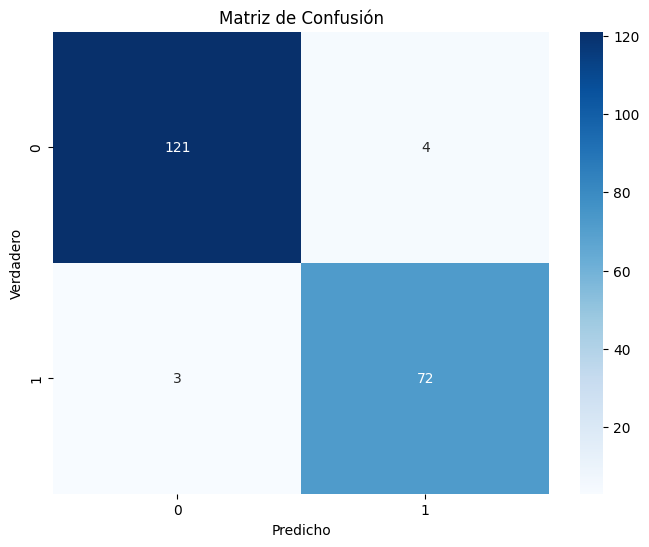

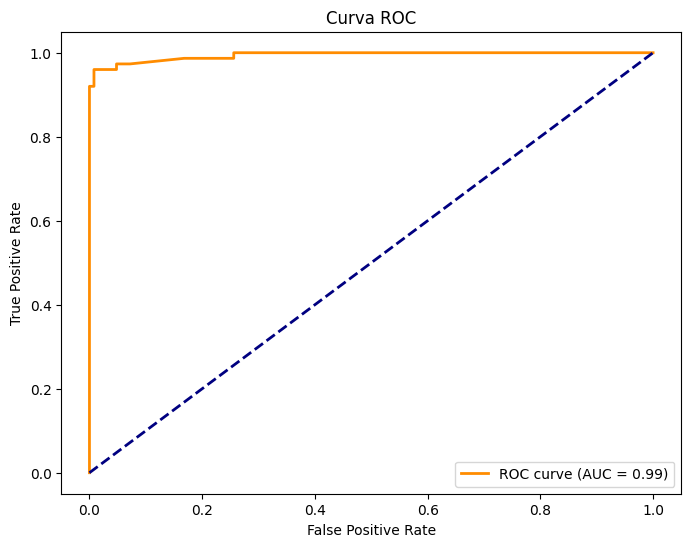

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Matriz de confusión
cm = confusion_matrix(data_val['label'], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Curva ROC
y_pred_proba = clf.predict_proba(X_val_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(data_val['label'], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(clf, X_train_tfidf, data_train['label'], cv=5)
print(f"Precisión con validación cruzada: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Precisión con validación cruzada: 0.955 (+/- 0.024)


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).

In [28]:
def evaluate_model(X_train, X_val, y_train, y_val, model_name="Modelo"):
    # Entrenamos el modelo
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_val)
    
    # Métricas
    print(f"\n=== Resultados para {model_name} ===")
    print("\nReporte de clasificación:")
    print(classification_report(y_val, y_pred))
    
    # Validación cruzada
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"\nPrecisión con validación cruzada: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    
    return clf, y_pred

In [29]:
# 1. Features básicos
def create_basic_features(train_df, val_df):
    features = ['text_len', 'money_mark', 'suspicious_words']
    return (
        train_df[features].values,
        val_df[features].values
    )

# 2. Features de texto avanzados
def create_advanced_features(train_df, val_df):
    # URLs y números
    train_df['url_count'] = train_df['text'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    train_df['number_count'] = train_df['text'].str.count(r'\d+')
    train_df['uppercase_ratio'] = train_df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
    
    val_df['url_count'] = val_df['text'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    val_df['number_count'] = val_df['text'].str.count(r'\d+')
    val_df['uppercase_ratio'] = val_df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
    
    features = ['text_len', 'money_mark', 'suspicious_words', 'url_count', 'number_count', 'uppercase_ratio']
    return (
        train_df[features].values,
        val_df[features].values
    )

In [30]:
def create_tfidf_features(train_texts, val_texts, config):
    vectorizer = TfidfVectorizer(**config)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    return X_train, X_val, vectorizer

# Diferentes configuraciones de TF-IDF
tfidf_configs = {
    'simple': {
        'max_features': 1000
    },
    'advanced': {
        'max_features': 2000,
        'min_df': 2,
        'max_df': 0.95,
        'ngram_range': (1, 2)
    },
    'complex': {
        'max_features': 3000,
        'min_df': 3,
        'max_df': 0.9,
        'ngram_range': (1, 3)
    }
}

In [37]:
from scipy.sparse import hstack
import numpy as np
# Crear todas las versiones de features
print("Creando features...")
X_train_basic, X_val_basic = create_basic_features(data_train, data_val)
X_train_advanced, X_val_advanced = create_advanced_features(data_train, data_val)

results = {}
for config_name, config in tfidf_configs.items():
    print(f"\nProbando configuración TF-IDF: {config_name}")
    
    # TF-IDF features
    X_train_tfidf, X_val_tfidf, vectorizer = create_tfidf_features(
        data_train['preprocessed_text'],
        data_val['preprocessed_text'],
        config
    )
    
    # Combinar con features básicos
    X_train_combined = hstack([X_train_tfidf, X_train_basic])
    X_val_combined = hstack([X_val_tfidf, X_val_basic])
    
    # Evaluar modelo
    clf, y_pred = evaluate_model(
        X_train_combined, 
        X_val_combined, 
        data_train['label'], 
        data_val['label'],
        f"TF-IDF {config_name} + features básicos"
    )
    
    # Guardar resultados
    results[config_name] = {
        'clf': clf,
        'y_pred': y_pred,
        'vectorizer': vectorizer
    }

# Mostrar las palabras más importantes para cada clase
def print_important_features(clf, vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    max_features = len(feature_names)
    n = min(n, max_features)  # Nos aseguramos de no exceder el tamaño del vocabulario
    
    for i, label in enumerate(['HAM', 'SPAM']):
        # Obtenemos los índices ordenados y nos aseguramos de que estén dentro del rango
        feature_log_probs = clf.feature_log_prob_[i]
        top_indices = np.argsort(feature_log_probs)
        top_indices = top_indices[top_indices < max_features]  # Filtramos índices válidos
        top_features = top_indices[-n:]  # Tomamos los últimos n índices
        
        print(f"\nTop {n} palabras más importantes para {label}:")
        top_words = [feature_names[j] for j in top_features if j < max_features]
        print(top_words)

# Encontrar la mejor configuración basada en la validación cruzada
cv_scores = {}
for config_name in results.keys():
    scores = cross_val_score(results[config_name]['clf'], 
                           X_train_combined, 
                           data_train['label'], 
                           cv=5)
    cv_scores[config_name] = scores.mean()

best_config = max(cv_scores.items(), key=lambda x: x[1])[0]

print(f"\n=== Mejor configuración: {best_config} ===")
print_important_features(results[best_config]['clf'], 
                       results[best_config]['vectorizer'])


Creando features...

Probando configuración TF-IDF: simple

=== Resultados para TF-IDF simple + features básicos ===

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       125
           1       0.94      0.89      0.92        75

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.94       200
weighted avg       0.94      0.94      0.94       200


Precisión con validación cruzada: 0.906 (+/- 0.043)

Probando configuración TF-IDF: advanced

=== Resultados para TF-IDF advanced + features básicos ===

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       125
           1       0.94      0.89      0.92        75

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.94       200
weighted avg       0.94      0.94      0.94       200


Precisión con valida


AUC-ROC Score: 0.931


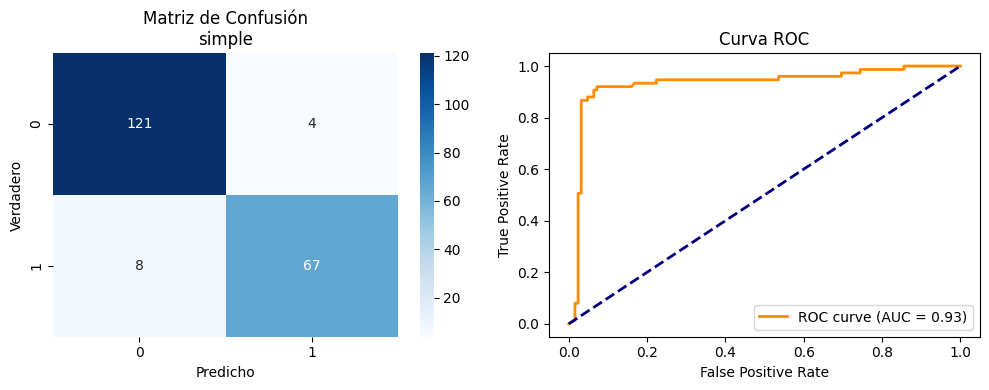

In [41]:
# Versión alternativa más robusta
plt.figure(figsize=(10, 4))

try:
    # Matriz de confusión
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(data_val['label'], results[best_config]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión\n{best_config}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')

    # Curva ROC
    plt.subplot(1, 2, 2)
    
    # Recreamos las features exactamente como se hicieron durante el entrenamiento
    X_val_tfidf, _, _ = create_tfidf_features(
        data_val['preprocessed_text'],
        data_val['preprocessed_text'],
        tfidf_configs[best_config]
    )
    X_val_basic = create_basic_features(data_train, data_val)[1]
    X_val_combined = hstack([X_val_tfidf, X_val_basic])
    
    # Calculamos probabilidades
    y_pred_proba = results[best_config]['clf'].predict_proba(X_val_combined)[:, 1]
    fpr, tpr, _ = roc_curve(data_val['label'], y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")

    print(f"\nAUC-ROC Score: {roc_auc:.3f}")

except Exception as e:
    print(f"Error al generar las visualizaciones: {str(e)}")
    
plt.tight_layout()
plt.show()